# Rendering Hendecagrams

This notebook contains a program for rendering a hendecagon (11-sided regular polygon), together with all its inscribed hendecagrams.  My approach here consciously adopts a couple of constraints. First, I compute everything with exact arithmetic, using integers rather than floating point numbers.  Second, I compute intersection points by applying proportions, rather than by intersecting lines.  In the end, I hope this serves as a beautiful demonstration of the power of very basic mathematics.

## Hendecagon Numbers

The first section of code below contains an implementation of the hendecagon number field, a field derived from the diagonals of the hendecagram as described in Steinbach2000 and Steinbach2004.  Following Steinbach's lead, I use $\theta$, $\kappa$, $\lambda$, and $\mu$ for the diagonals of a unit-sided hendecagram, in order of increasing length.  Any field element has the form $a+b\theta+c\kappa+d\lambda+e\mu$, for some rational numbers $a$, $b$, $c$, $d$, and $e$.

Given the table of basic products and quotients below, I can scale any number or vector up or down by factors of $\theta$, $\kappa$, $\lambda$, and $\mu$.  With this ability, I don't actually require general division, so I can limit my coefficients to integers rather than rationals.

|          | $\theta$ | $\kappa$ | $\lambda$ | $\mu$ |
|----------|----------|---------|----------|----------|
| $\theta$ | $\theta\theta=1+\kappa$ | $\theta\kappa=\theta+\lambda$ | $\theta\lambda=\kappa+\mu$ | $\theta\mu=\lambda+\mu$ |
| $\kappa$  |         | $\kappa\kappa=1+\kappa+\mu$ | $\kappa\lambda=\theta+\lambda+\mu$ | $\kappa\mu=\kappa+\lambda+\mu$ |
| $\lambda$ |         |         | $\lambda\lambda=1+\kappa+\lambda+\mu$ | $\lambda\mu=\theta+\kappa+\lambda+\mu$ |
| $\mu$ |         |         |         | $\mu\mu=1+\theta+\kappa+\lambda+\mu$ |

|          | $\theta$ | $\kappa$ | $\lambda$ | $\mu$ |
|----------|----------|---------|----------|----------|
| $1$ | $1/\theta=1+\theta-\kappa-\lambda+\mu$ | $1/\kappa=\theta+\kappa-\lambda-1$ | $1/\lambda=\lambda-\theta-1$ | $1/\mu=\mu-\lambda$ |
| $\theta$ |         | $\theta/\kappa=1+\lambda-\mu$ | $\theta/\lambda=\lambda-\theta-1$ | $\theta/\mu=\lambda-\kappa$ |
| $\kappa$  | $\kappa/\theta=\kappa+\lambda-\mu-1$ |     | $\kappa/\lambda=\mu-\kappa$ | $\kappa/\mu=\kappa-\theta$ |
| $\lambda$ | $\lambda/\theta=\kappa-1$ | $\lambda/\kappa=\theta+\mu-\lambda-1$ |  | $\lambda/\mu=\theta-1$ |
| $\mu$ | $\mu/\theta=1+\mu-\kappa$ | $\mu/\kappa=\lambda-\theta$ | $\mu/\lambda=\theta+\kappa-\mu$ |  $ $ |

All of these products and quotients can be derived using basic geometry, by considering various similar triangles in the hendecagon and inscribed hendecagrams.  I've explained the technique in more detail with respect to the [heptagon field](http://nbviewer.ipython.org/github/vorth/ipython/blob/master/heptagons/HeptagonNumbers.ipynb).

The code below is mostly a collection of special functions, to overload arithmetic operators for the class.  This will be very important for readability of the code later in the notebook.

In [1]:
import math

class HendecagonNumber(object):
    def __init__( self, ones=0, theta=0, kappa=0, _lambda=0, mu=0 ):
        self.ones = ones
        self.theta = theta
        self.kappa = kappa
        self._lambda = _lambda
        self.mu = mu

    def __add__( self, rhs ):  #self and rhs are HendecagonNumber objects
        return HendecagonNumber(
                self.ones+rhs.ones,
                self.theta+rhs.theta,
                self.kappa+rhs.kappa,
                self._lambda+rhs._lambda,
                self.mu+rhs.mu )

    def __sub__( self, rhs ):  #self and rhs are HendecagonNumber objects
        return HendecagonNumber(
                self.ones-rhs.ones,
                self.theta-rhs.theta,
                self.kappa-rhs.kappa,
                self._lambda-rhs._lambda,
                self.mu-rhs.mu )

    def __neg__( self ) :
        return HendecagonNumber( -self.ones, -self.theta, -self.kappa, -self._lambda, -self.mu )

    def timestheta( self ) :
        return HendecagonNumber(
                self.theta,
                self.ones + self.kappa,
                self.theta + self._lambda,
                self.kappa + self.mu,
                self._lambda + self.mu )

    def timeskappa( self ) :
        return HendecagonNumber(
                self.kappa,
                self.theta + self._lambda,
                self.ones + self.kappa + self.mu,
                self.theta + self._lambda + self.mu,
                self.kappa + self._lambda + self.mu )

    def times_lambda( self ) :
        return HendecagonNumber(
                self._lambda,
                self.kappa + self.mu,
                self.theta + self._lambda + self.mu,
                self.ones + self.kappa + self._lambda + self.mu,
                self.theta + self.kappa + self._lambda + self.mu )
    
    def timesmu( self ) :
        return HendecagonNumber(
                self.mu,
                self._lambda + self.mu,
                self.kappa + self._lambda + self.mu,
                self.theta + self.kappa + self._lambda + self.mu,
                self.ones + self.theta + self.kappa + self._lambda + self.mu )

    def __mul__( self, rhs ) :
        if isinstance( rhs, self.__class__ ):
            return ( self * rhs.ones ) .__add__(
                ( self .timestheta() * rhs.theta ) .__add__(
                ( self .timeskappa() * rhs.kappa ) .__add__(
                ( self .times_lambda() * rhs._lambda ) .__add__(
                ( self .timesmu() * rhs.mu ) ) ) ) )
        elif isinstance( rhs, int ):
            return HendecagonNumber(
                self.ones*rhs,
                self.theta*rhs,
                self.kappa*rhs,
                self._lambda*rhs,
                self.mu*rhs )
        else:
            raise TypeError("unsupported operand type(s) for +: '{}' and '{}'").format(self.__class__, type(other))

    def __str__( self ):
        s = u""
        if self.ones != 0 :
            s = s + u"%d" % ( self.ones )
        if self.theta != 0 :
            if len(s) > 0 :
                s = s + u"+"
            if self.theta != 1 :
                s = s + u"%d" % ( self.theta )
            s = s + u"\u03B8"
        if self.kappa != 0 :
            if len(s) > 0 :
                s = s + u"+"
            if self.kappa != 1 :
                s = s + u"%d" % ( self.kappa )
            s = s + u"\u03BA"
        if self._lambda != 0 :
            if len(s) > 0 :
                s = s + u"+"
            if self._lambda != 1 :
                s = s + u"%d" % ( self._lambda )
            s = s + u"\u03BB"
        if self.mu != 0 :
            if len(s) > 0 :
                s = s + u"+"
            if self.mu != 1 :
                s = s + u"%d" % ( self.mu )
            s = s + u"\u03BC"
        return s.encode('utf-8') 

    theta_real = 2 * math.sin(9*math.pi/22)
    _lambda_real = 2 * theta_real * math.sin(7*math.pi/22)
    kappa_real = 2 * _lambda_real * math.sin(3*math.pi/22)
    mu_real = 2 * kappa_real * math.sin(5*math.pi/22)
    
    def __float__( self ) :
        return self.ones + self.theta_real * self.theta + \
            self.kappa_real * self.kappa + \
            self._lambda_real * self._lambda + \
            self.mu_real * self.mu

zero = HendecagonNumber()
one = HendecagonNumber(1)
theta = HendecagonNumber(0,1)
kappa = HendecagonNumber(0,0,1)
_lambda = HendecagonNumber(0,0,0,1)
mu = HendecagonNumber(0,0,0,0,1)
theta_inv = one + theta - kappa - _lambda + mu
kappa_inv = theta + kappa - _lambda - one
lambda_inv = _lambda - theta - one
mu_inv = mu - _lambda

print str(theta) + " = " + str(HendecagonNumber.theta_real)
print str(kappa) + " = " + str(HendecagonNumber.kappa_real)
print str(_lambda) + " = " + str(HendecagonNumber._lambda_real)
print str(mu) + " = " + str(HendecagonNumber.mu_real)

def printProd( h1, h2 ) :
    print str(h1) + str(h2) + " = " + str(h1*h2)
    
printProd( kappa, mu )
printProd( theta, _lambda )
printProd( kappa, kappa )
printProd( theta, mu )
printProd( mu, mu )
printProd( mu, 4 )


θ = 1.91898594723
κ = 2.68250706566
λ = 3.22870741512
μ = 3.51333709167
κμ = κ+λ+μ
θλ = κ+μ
κκ = 1+κ+μ
θμ = λ+μ
μμ = 1+θ+κ+λ+μ
μ4 = 4μ


## Vectors and Rendering

The next section of code is a simple implementation of two-dimensional vectors over the hendecagon numbers.  The only noteworthy point here is the render function, which does two things.  First, it converts the coordinate hendecagon numbers to real numbers.  Next, it performs a skew transformation to map from the initial coordinate frame to the frame I need to use for drawing.  These coordinate frames are different because the first one allows a simple encoding of the hendecagon vertices, using a frame aligned with a diagonal of the hendecagon.  This simplifies all the later computations based on these vertices.  The only cost is to perform the skew transformation when it is time to render to the screen.

<img src="hendecagon-coordinates-skew.png" />

The code to generate the figure above is found later in the notebook.

In [2]:

class Vector(object):

    def __init__( self, x, y ):
        self.x = x
        self.y = y

    def __mul__( self, rhs ) :
        return Vector( rhs .__mul__( self.x ), rhs .__mul__( self.y ) )

    def __add__( self, rhs ) :
        return Vector( self.x + rhs.x, self.y + rhs.y )

    def __sub__( self, rhs ) :
        return Vector( self.x - rhs.x, self.y - rhs.y )

    def __neg__( self ) :
        return Vector( -self.x, -self.y )

    def render( self ):
        x = float( self.x )
        y = float( self.y )
        A = math.sin( (5.0/11.0) * math.pi )
        x = float( self.x ) + float( self.y ) / (2*HendecagonNumber.mu_real)
        y = A * float( self.y )
        return [ x, y ]

origin = Vector( zero, zero )


## Hendecagon Vertices

The code below defines the vertices of the hendecagon, then constructs lists of those vertices representing the hendecagon and all four of the inscribed hendecagrams.

In [3]:

p = [ Vector( theta * kappa, zero ) for x in range(11) ]
p[0] = Vector( theta * kappa, zero )
p[1] = Vector( kappa * _lambda, zero )
p[2] = Vector( _lambda * mu, theta )
p[3] = Vector( mu * mu, theta * kappa )
p[4] = Vector( _lambda * mu, kappa * _lambda )
p[5] = Vector( kappa * _lambda, _lambda * mu )
p[6] = Vector( theta * kappa, mu * mu )
p[7] = Vector( theta, _lambda * mu )
p[8] = Vector( zero, kappa * _lambda )
p[9] = Vector( zero, theta * kappa )
p[10] = Vector( theta, theta )

hendecagon = [ p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10] ]

hendecagram_theta = [ p[0], p[2], p[4], p[6], p[8], p[10], p[1], p[3], p[5], p[7], p[9] ]

hendecagram_kappa = [ p[0], p[3], p[6], p[9], p[1], p[4], p[7], p[10], p[2], p[5], p[8] ]

hendecagram_lambda = [ p[0], p[4], p[8], p[1], p[5], p[9], p[2], p[6], p[10], p[3], p[7] ]

hendecagram_mu = [ p[0], p[5], p[10], p[4], p[9], p[3], p[8], p[2], p[7], p[1], p[6] ]



## Strips for 1/11th of the Figure

The code in this section is where everything interesting happens.  The drawSectorRibbons function will be called eleven times, each time starting with a different index in the heptagon vertices, to render the next eleventh of the final figure.  Based on the eleven vertices it is given, it computes unit vectors for all eleven directions.  Next, it computes the intersection points among the diagonals (heptagram edges).  It does this not by the usual line-line intersection techniques, but rather by adding scaled vectors to the hendecagon vertices.

I have used an indexing scheme that is a little hard to describe, and I intend to insert a scan of one my worksheets here.  In the meantime, here is a quick description: indexing is based on the eleven unit vectors according to how they pass through two ends of the hendecagon edge, $p5$ and $p6$.  There are additional parallel lines that do not intersect those endpoints, but do cross the section being rendered.  Those lines have a doubled or tripled index.  The intersections between lines are indexed by the two line indices.  There are also a collection of scale factors used to express all the proportions used to compute the intersections.  I'm sure I have used more complicated constructions than I needed to, in some cases.

Once all the intersections have been computed, the next step is to compute the rhombus of four points that will be used to terminate two of the strips near each intersection.  Here, again, I have avoided the need for linear algebra.  This is possible because each rhombus already exists in the figure, just at a larger scale.  There are four types of rhombuses, with different "aspect ratios".  By applying a consistent scale-down factor to the unit vectors, I can arrive at the points I need, knowing that my strips will all have the same width.  The scale-down factor was adjusted so that the smallest triangle in the figure would not generate intersecting strips.



In [10]:

# greens and magentas
one_color = "#71A89C"
theta_color = "#9E1C38"
kappa_color = "#14856C"
lambda_color = "#DE8397"
mu_color = "#83DECA"

# rainbow
one_color = "#C24040"
theta_color = "#DB9F32"
kappa_color = "#88CF5D"
lambda_color = "#8CD4D0"
mu_color = "#CACAE6"

# oranges and blues
one_color = "#EDAA53"
theta_color = "#666699"
kappa_color = "#DB8B09"
lambda_color = "#9999cc"
mu_color = "#EDC88C"

def drawSectorRibbons( p, drawEdge, drawStrip ):

    #unit vectors

    u = [ ( p[5] - p[6] ) for x in range(12) ]
    u[0] = p[5] - p[6]
    u[1] = (p[4] - p[6]) * theta_inv
    u[2] = (p[3] - p[6]) * kappa_inv
    u[3] = (p[2] - p[6]) * lambda_inv
    u[4] = (p[1] - p[6]) * mu_inv
    u[5] = (p[0] - p[5]) * mu_inv
    u[6] = (p[10] - p[5]) * mu_inv
    u[7] = (p[9] - p[5]) * lambda_inv
    u[8] = (p[8] - p[5]) * kappa_inv
    u[9] = (p[7] - p[5]) * theta_inv
    u[10] = - u[0]
    u[11] = (p[0] - p[6]) * mu_inv

    # scale factors for various segments of heptagram diagonals
    s812 = theta * lambda_inv - kappa_inv
    s278 = theta * mu_inv * lambda_inv
    s267 = theta * mu_inv * mu_inv
    s367 = theta * mu_inv - lambda_inv
    s406 = _lambda * kappa_inv
    s489 = theta * mu_inv - mu_inv
    s2006 = one - ( s267 + s278 + s812 + kappa_inv )
    s3099 = theta * theta * lambda_inv
    s4088 = theta * kappa * mu_inv
    s6002 = s2006 * theta * lambda_inv
    s7002 = theta * kappa_inv * ( s267 + s2006 )

    p15 = p[6] + u[1]
    p16 = p[5] + u[6] * mu_inv
    p17 = p[5] + u[7] * lambda_inv
    p18 = p[5] + u[8] * kappa_inv
    p19 = p[6] + u[1] * theta_inv

    p28 = p18 + u[8] * s812
    p27 = p28 + u[2] * s278
    p26 = p27 + u[2] * s267
    p29 = p[6] + u[2] * kappa_inv

    p36 = p[6] + u[3]
    p35 = p[5] + u[5]
    p37 = p36 - u[3] * s367
    p38 = p28 + u[8] * s278
    p39 = p[6] + u[3] * lambda_inv

    p45 = p[5] + u[5] * _lambda * theta_inv
    p46 = p[6] + u[4] * s406
    p47 = p[5] + u[7]
    p48 = p38 + u[8] * s267
    p49 = p[6] + u[4] * mu_inv

    p002 = p[6] + u[2]
    p003 = p38 + u[3] * s7002
    p004 = p48 + u[4] * s6002
    p005 = p15 + u[5] * s489
    p006 = p26 + u[6] * s6002
    p007 = p27 + u[7] * s7002
    p008 = p[7] + u[0]
    p113 = p[6] + u[3] * theta_inv * kappa
    p114 = p[6] + u[4]
    p115 = p[5] + u[5] * theta * theta * mu_inv
    p116 = p[5] + u[6] * theta * theta * mu_inv
    p224 = p[6] + u[4] * _lambda * theta_inv
    p225 = p[5] + u[5] * theta * kappa * lambda_inv
    p399 = p[6] + u[3] * s3099
    p411 = p[5] + u[7] * theta * theta * lambda_inv
    p488 = p[6] + u[4] * s4088
    p499 = p[6] + u[4] * theta * theta * mu_inv
    p588 = p[5] + u[5] * s406
    p599 = p[4] + u[9]
    p699 = p[5] + u[6]
    p0004 = p[6] + u[4] * theta * kappa * lambda_inv
    p2288 = p[7] + u[2] * theta * kappa * lambda_inv
    p0005 = p[5] + u[5] * s4088
    p00022 = p[7] + u[2] * _lambda * theta_inv
    p1199 = p[7] + u[1] * theta_inv * kappa

    p25 = p005 + u[5] * s6002

    # the global scale factor, mapping the kappa-one strip width
    #   to the target strip width
    f = mu_inv * mu_inv * lambda_inv
    
    # rhombus aspect ratios, indexed by smaller interior
    #  angle as a multiple of pi/11
    f3 = f * theta * kappa_inv
    f4 = f * theta * lambda_inv
    f5 = f * theta * mu_inv

    # scale factor for the hendecagon vertices
    g = mu_inv * lambda_inv * theta_inv

    def strip( axis, tail, tailRatio, tailCross, head, headRatio, headCross, color ):
        a = tail + ( axis - tailCross ) * tailRatio
        b = head - ( headCross + axis ) * headRatio
        c = head + ( headCross - axis ) * headRatio
        d = tail + ( axis + tailCross ) * tailRatio
        drawStrip( a, b, c, d, color )
    
    strip( u[2], p28, f4, u[8], p26, f5, u[6], kappa_color )
    strip( u[8], p18, f3, u[1], p38, f5, u[3], kappa_color )
    strip( u[2], p26, f5, u[6], p25, f4, u[5], kappa_color )
    strip( u[0], p007, f3, u[7], p002, f, u[2], kappa_color )
    strip( u[8], p38, f5, u[3], p008, f, u[0], kappa_color )
    strip( u[0], p004, f4, u[4], p007, f3, u[7], kappa_color )

    strip( u[6], p006, f4, u[0], p699, f3, -u[9], mu_color )
    strip( u[4], p48, f5, u[8], p47, f5, u[7], mu_color )
    strip( u[6], p699, f3, -u[9], p46, f3, u[4], mu_color )
    strip( u[4], p47, f4, u[7], p499, f5, u[9], mu_color )
    strip( u[4], p499, f5, u[9], p488, f5, u[8], mu_color )
    strip( u[4], p488, f5, u[8], p224, f, -u[2], mu_color )
    strip( u[8], p588, f3, u[5], p2288, f4, u[2], mu_color )
    strip( u[2], p00022, f, -u[0], p225, f4, u[5], mu_color )
    strip( u[6], p16, f5, u[1], p006, f4, u[0], mu_color )

    strip( u[3], p36, f4, u[6], p35, f3, u[5], lambda_color )
    strip( u[1], p114, f3, u[4], p116, f5, u[6], lambda_color )
    strip( u[1], p116, f5, u[6], p113, f, u[3], lambda_color )
    strip( u[9], p399, f4, u[3], p1199, f, u[1], lambda_color )
    strip( u[3], p003, f3, -u[0], p36, f5, u[6], lambda_color )
    strip( u[3], p39, f4, u[9], p003, f3, -u[0], lambda_color )
    strip( u[7], p27, f5, u[2], p37, f5, u[3], lambda_color )
    strip( u[7], p37, f5, u[3], p411, f4, u[1], lambda_color )

    strip( u[1], p17, f4, u[7], p15, f5, u[5], theta_color )
    strip( u[1], p19, f, u[9], p17, f4, u[7], theta_color )
    strip( u[9], p29, f3, u[2], p49, f5, u[4], theta_color )

    # strips reaching the hendecagon vertices
    
    def vertexStrip( axisIndex, head, headRatio, headCross, tail, color ):
        a = head - ( u[axisIndex] + headCross ) * headRatio
        b = tail + ( u[axisIndex] + u[axisIndex+1] ) * g
        c = tail + ( u[axisIndex] + u[axisIndex-1] ) * g
        d = head + ( headCross - u[axisIndex] ) * headRatio
        drawStrip( a, b, c, d, color )
    
    vertexStrip( 8, p18, f3, u[1], p[5], kappa_color )
    vertexStrip( 2, p28, f4, -u[8], p[6], kappa_color )
    vertexStrip( 7, p27, f5, u[2], p[5], lambda_color )
    vertexStrip( 3, p39, f4, -u[9], p[6], lambda_color )
    vertexStrip( 9, p29, f3, u[2], p[5], theta_color )
    vertexStrip( 1, p19, f, -u[9], p[6], theta_color )
    vertexStrip( 6, p16, f5, u[1], p[5], mu_color )
    u[5] = u[11]
    vertexStrip( 4, p48, f5, -u[8], p[6], mu_color )

    a = p[6] + ( u[0] - u[9] ) * g
    b = p[5] - ( u[0] + u[1] ) * g
    c = p[5] + ( u[9] - u[0] ) * g
    d = p[6] + ( u[0] + u[1] ) * g
    e = p[6] - ( u[8] + u[0] ) * f
    f = p[5] + ( u[0] - u[2] ) * f
    drawStrip( a, b, c, d, one_color )
    drawEdge( a, e )
    drawEdge( b, f )
    

Populating the interactive namespace from numpy and matplotlib


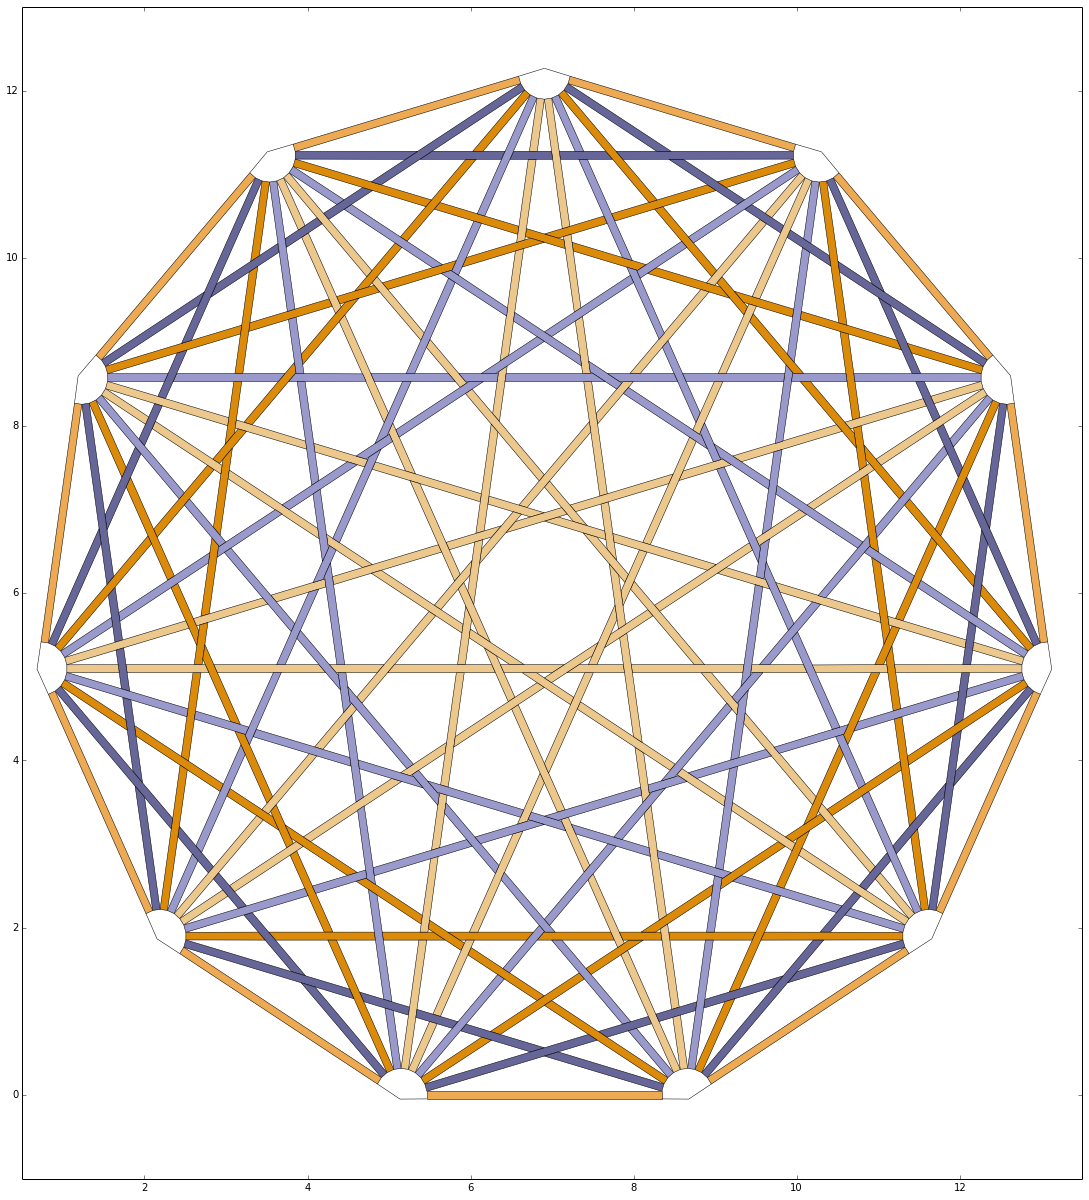

In [11]:
%pylab --no-import-all inline

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
Path = mpath.Path

def drawPolygon( polygonVerts, color ):
    n = len( polygonVerts )
    codes = [ Path.MOVETO ]
    verts = []
    verts .append( polygonVerts[ 0 ] .render() )
    for i in range(1,n+1):
        codes.append ( Path.LINETO )
        verts.append ( polygonVerts[ i % n ] .render() )
    path = mpath.Path( verts, codes )
    return mpatches.PathPatch( path, facecolor='none', edgecolor=color )

fig = plt.figure(figsize=(21*13/14,21))

#fig = plt.figure(figsize=(12,24))
#fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
#ax.set_xlim(6.5,10.5)
#ax.set_ylim(4.5,12.5)
#ax.set_xlim(9,10.5)
#ax.set_ylim(8.5,11.5)

ax.set_xlim(0.5,13.5)
ax.set_ylim(-1,13)

#ax.add_patch( drawPolygon( hendecagon, '#cccccc' ) )
#ax.add_patch( drawPolygon( hendecagram_theta, orange ) )
#ax.add_patch( drawPolygon( hendecagram_kappa, kappa_color ) )
#ax.add_patch( drawPolygon( hendecagram_lambda, lambda_color ) )
#ax.add_patch( drawPolygon( hendecagram_mu, mu_color ) )

def drawEdge( p1, p2, color="#000000" ):
    codes = [ Path.MOVETO ]
    verts = []
    verts .append( p1 .render() )
    codes.append ( Path.LINETO )
    verts.append ( p2 .render() )
    path = mpath.Path( verts, codes )
    ax.add_patch( mpatches.PathPatch( path, facecolor='none', lw=0.5, edgecolor=color ) )

def drawStrip( p1, p2, p3, p4, color="none" ):
    codes = [ Path.MOVETO ]
    verts = []
    verts .append( p1 .render() )
    codes.append ( Path.LINETO )
    verts.append ( p2 .render() )
    codes.append ( Path.LINETO )
    verts.append ( p3 .render() )
    codes.append ( Path.LINETO )
    verts.append ( p4 .render() )
    codes.append ( Path.LINETO )
    verts.append ( p1 .render() )
    path = mpath.Path( verts, codes )
    ax.add_patch( mpatches.PathPatch( path, facecolor=color, lw=0.5, edgecolor="#000000" ) )

for i in range(11):
    pRot = []
    for j in range(11):
        k = (j+i) % 11
        pRot .append( p[ k ] )
    drawSectorRibbons( pRot, drawEdge, drawStrip )


#ax.axis('off')
#fig.savefig( "hendecagonWoven-greens.pdf" )


## The Skew Coordinates

Populating the interactive namespace from numpy and matplotlib


(-1, 14)

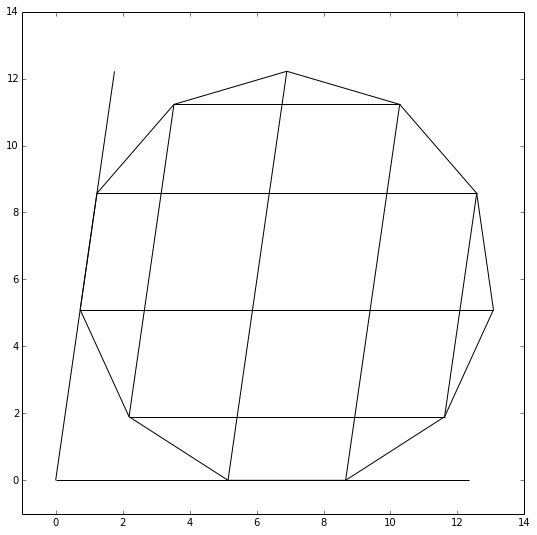

In [9]:
%pylab --no-import-all inline

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
Path = mpath.Path

def drawPolygon( polygonVerts ):
    n = len( polygonVerts )
    codes = [ Path.MOVETO ]
    verts = []
    verts .append( polygonVerts[ 0 ] .render() )
    for i in range(1,n+1):
        codes.append ( Path.LINETO )
        verts.append ( polygonVerts[ i % n ] .render() )
    path = mpath.Path( verts, codes )
    return mpatches.PathPatch( path, facecolor='none', edgecolor='#000000' )

def drawDiagonal( v1, v2 ):
    codes = [ Path.MOVETO ]
    verts = []
    verts .append( v1 .render() )
    codes.append ( Path.LINETO )
    verts.append ( v2 .render() )
    path = mpath.Path( verts, codes )
    return mpatches.PathPatch( path, facecolor='none', edgecolor='#000000' )

xAxis = Vector( mu * mu, zero )
yAxis = Vector( zero, mu * mu )

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
ax.add_patch( drawPolygon( hendecagon,  ) )
ax.add_patch( drawDiagonal( origin, xAxis ) )
ax.add_patch( drawDiagonal( origin, yAxis ) )
ax.add_patch( drawDiagonal( p[0], p[6] ) )
ax.add_patch( drawDiagonal( p[1], p[5] ) )
ax.add_patch( drawDiagonal( p[2], p[4] ) )
ax.add_patch( drawDiagonal( p[10], p[7] ) )
ax.add_patch( drawDiagonal( p[10], p[2] ) )
ax.add_patch( drawDiagonal( p[9], p[3] ) )
ax.add_patch( drawDiagonal( p[8], p[4] ) )
ax.add_patch( drawDiagonal( p[7], p[5] ) )

ax.set_xlim(-1,14)
ax.set_ylim(-1,14)

#ax.axis('off')
#fig.savefig( "hendecagon-coordinates-skew.jpg" )


$$\frac{1}{\mu} \frac{\kappa}{\mu} \frac{\lambda}{\mu} \frac{\theta}{\mu} $$